In [6]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

import pickle
from pprint import pprint

# Data Loading

In [110]:
# Load data
output = pickle.load(open("experiment_results.pickle", "rb"))
output_top91 = pickle.load(open("experiment_results_top91.pickle", "rb"))

output.update(output_top91)

# Files in scope
for file_name in output:
    print("File:", file_name, ", #sudokus:", len(output[file_name]))

File: 100_easy_sudokus , #sudokus: 100
File: damnhard.sdk , #sudokus: 35
File: top91.sdk , #sudokus: 91


In [111]:
# Show heuristics performance on selected variables

def get_heuristics_metrics_data(heuristics, biased = False):
    df = pd.DataFrame(columns=["backtracks",
                                        "flips",
                                        "var_picks",
                                        "norm_simplifications",
                                        "heuristic",
                                        "biased_coin",
                                        "bit_length",
                                        "mean_compression",
                                        "file_name"])
    for file_name in output:
        for sudoku_id in output[file_name]:
            for heuristic in heuristics:
                df = df.append({
                    "backtracks":float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_backtracks"]), 
                    "flips": float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_flips"]),
                    "var_picks": float(output[file_name][sudoku_id][(heuristic, biased)]["number_of_var_picks"]),
                    "norm_simplifications": float(output[file_name][sudoku_id][(heuristic, biased)]["simplifications"]),
                    "heuristic": str(heuristic),
                    "biased_coin": str(biased),
                    "bit_length": float(output[file_name][sudoku_id]["entropy"]),
                    "mean_compression": np.mean(output[file_name][sudoku_id]["min_compression"]),
                    "file_name": str(file_name)
                }, ignore_index=True) 
                
    # Transform to log
    df["log_backtracks"] = np.log(df["backtracks"] + 1)
    df["log_flips"] = np.log(df["flips"] + 1)
    df["flips_ratio"] = df["flips"] / (df["backtracks"] + 1)
    df["log_var_picks"] = np.log(df["var_picks"] + 1)
    df["log_norm_simplifications"] = np.log((df["norm_simplifications"] / (df["backtracks"] + 1)) + 1)
                
    return df

In [112]:
# TODO: Select relevant metrics
heuristics = [None, "MOM", "literalcount", "Jeroslow"]
df_unbiased = get_heuristics_metrics_data(heuristics, biased = False)

# Heuristics effect

In [115]:
def boxplot_heuristics(metric):
    plt.figure(figsize=(10,5))
    sns.boxplot(y="heuristic", x=metric, hue="file_name", showfliers=False, data=df_unbiased)
    plt.legend(loc=9, bbox_to_anchor=(1.15, 0.6))
    plt.show()

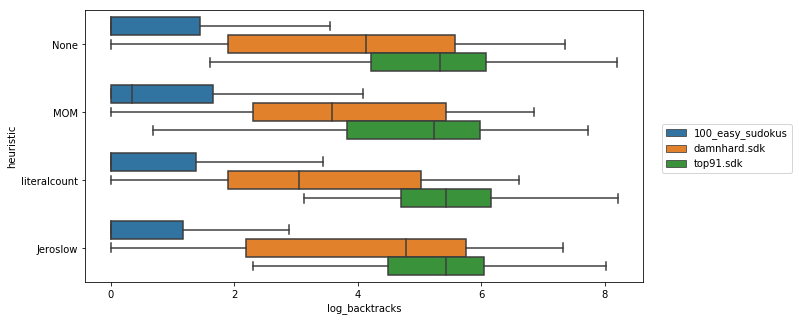

In [116]:
boxplot_heuristics("log_backtracks")

# Biased Coin Effect

In [117]:
# Check for importance of biased coin
df_biased = get_heuristics_metrics_data(heuristics, biased = True)    

In [118]:
def plot_biased_boxplot(heuristic, metric):
    print("-"*50)
    print(heuristic, metric, "\n")
    
    # Concatenate data
    df_compare_bias = pd.concat([df_unbiased, df_biased])
    
    #subselect data
    df_compare_bias = df_compare_bias.loc[(df_compare_bias["heuristic"] == str(heuristic))]
    
    plt.figure(figsize=(10,5))
    ax = sns.boxplot(y=metric, x="biased_coin", showfliers=False, orient = "v", data=df_compare_bias)
    add_stat_annotation(ax, data=df_compare_bias, y=metric, x="biased_coin",
                    boxPairList=[("False", "True")],
                    test='t-test_ind', textFormat='star', loc='outside', verbose=2)

    plt.show()


def plot_biased_distribution(heuristic, metric):
    #subselect data
    df_heuristic_biased = df_biased.loc[(df_biased["heuristic"] == str(heuristic))]
    df_heuristic_unbiased = df_unbiased.loc[(df_unbiased["heuristic"] == str(heuristic))]

    #plot
    sns.kdeplot(df_heuristic_biased[metric], shade=True, label = "biased")
    sns.kdeplot(df_heuristic_unbiased[metric], shade=True, label = "unbiased")
    plt.title(str(heuristic) + str(metric))
    plt.legend(loc=9)    

--------------------------------------------------
None backtracks 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=1.462e-01 stat=1.455e+00


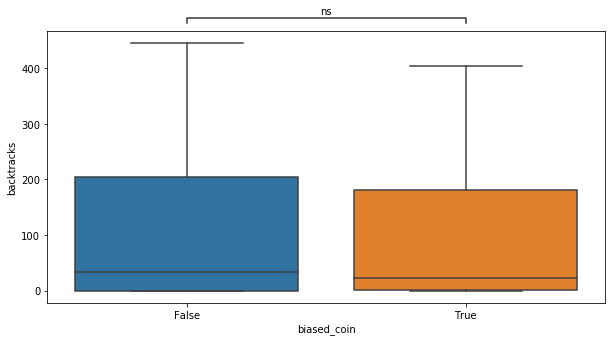

--------------------------------------------------
None flips 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=1.526e-01 stat=1.433e+00


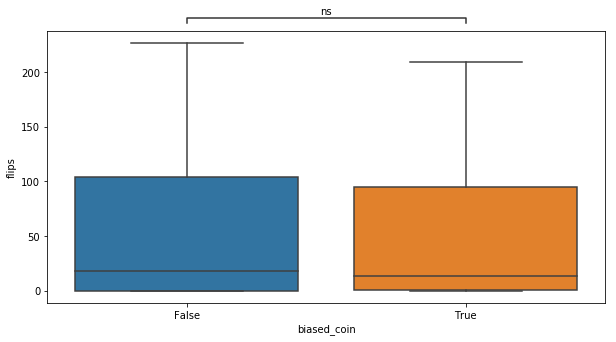

--------------------------------------------------
None var_picks 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=1.358e-01 stat=1.494e+00


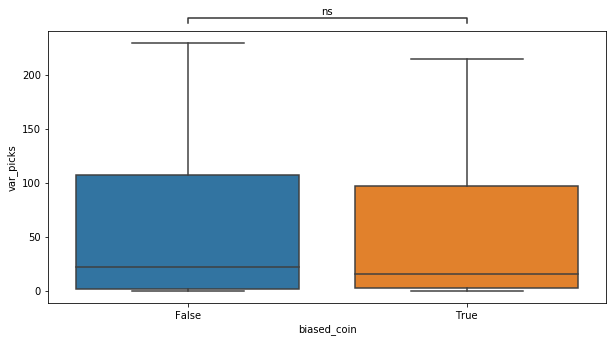

--------------------------------------------------
None norm_simplifications 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=1.759e-01 stat=1.356e+00


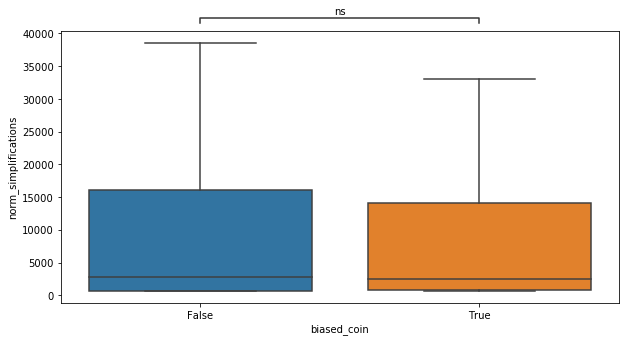

--------------------------------------------------
MOM backtracks 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=8.097e-01 stat=-2.410e-01


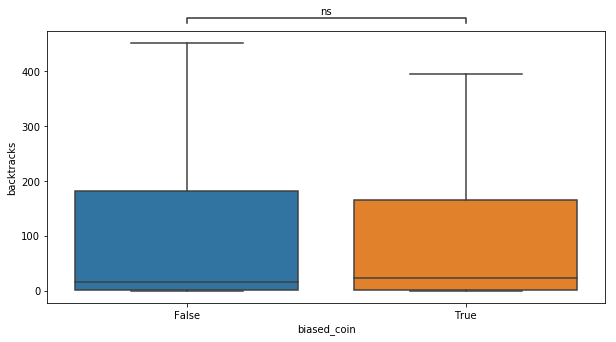

--------------------------------------------------
MOM flips 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=7.781e-01 stat=-2.820e-01


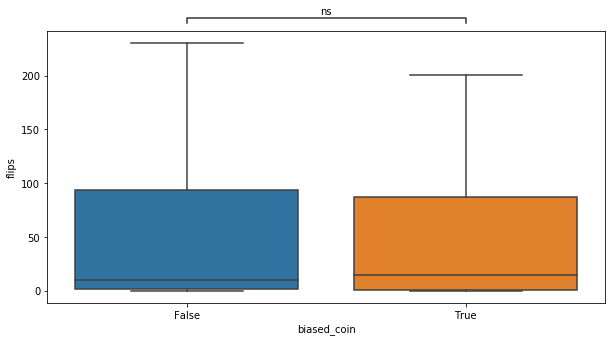

--------------------------------------------------
MOM var_picks 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=8.537e-01 stat=-1.845e-01


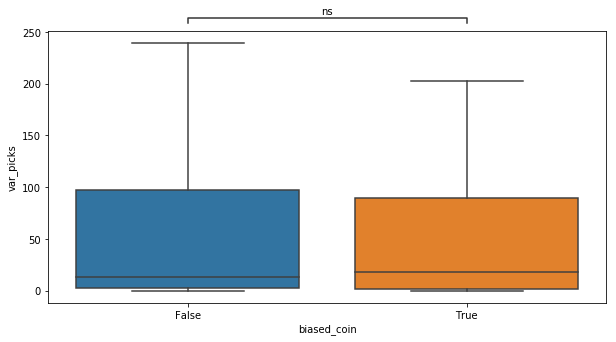

--------------------------------------------------
MOM norm_simplifications 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=7.727e-01 stat=-2.890e-01


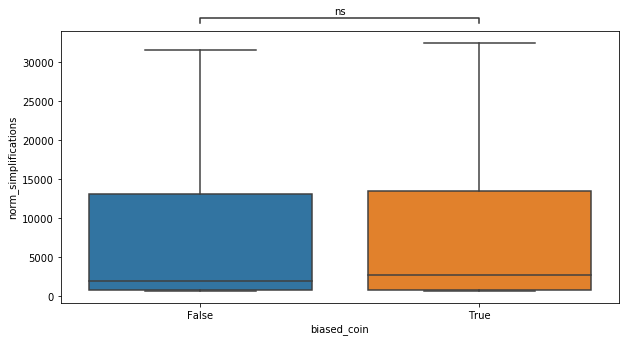

--------------------------------------------------
literalcount backtracks 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=5.193e-01 stat=-6.450e-01


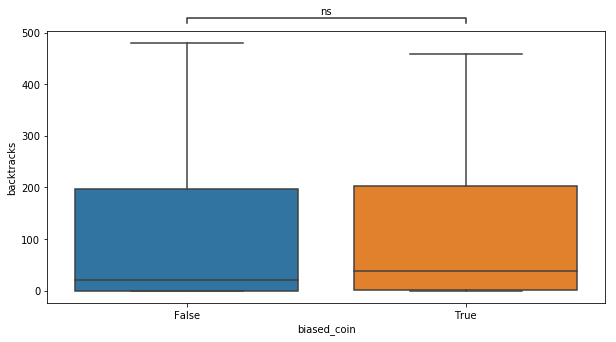

--------------------------------------------------
literalcount flips 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=5.136e-01 stat=-6.538e-01


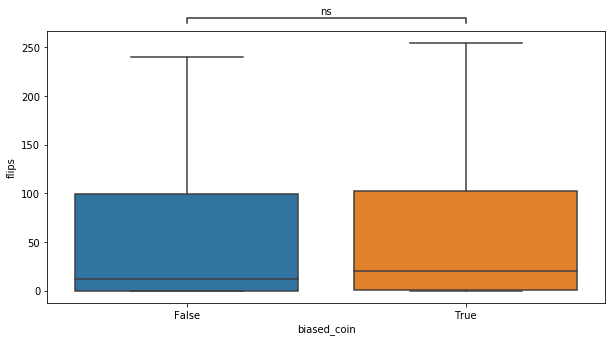

--------------------------------------------------
literalcount var_picks 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=5.291e-01 stat=-6.298e-01


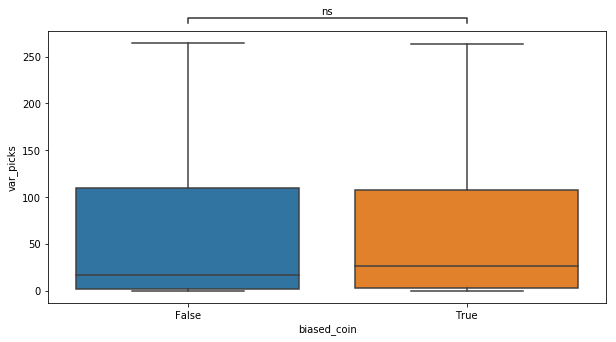

--------------------------------------------------
literalcount norm_simplifications 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=5.128e-01 stat=-6.550e-01


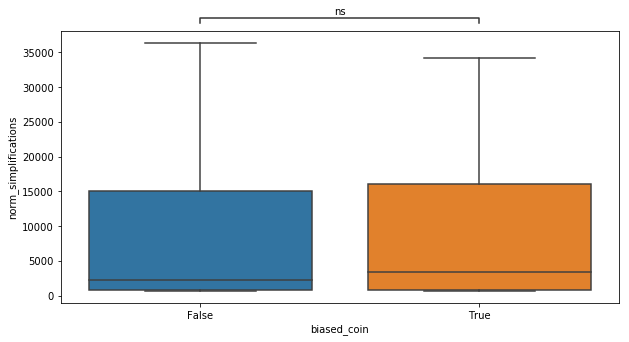

--------------------------------------------------
Jeroslow backtracks 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=7.373e-01 stat=3.357e-01


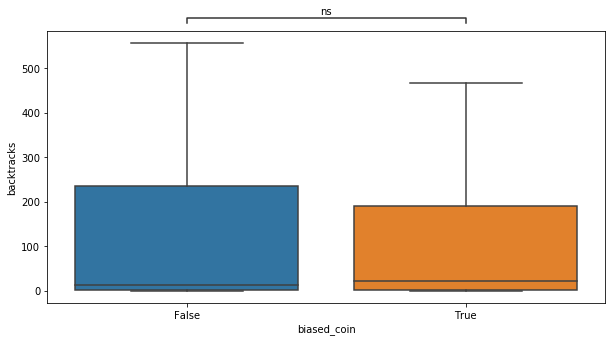

--------------------------------------------------
Jeroslow flips 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=7.659e-01 stat=2.979e-01


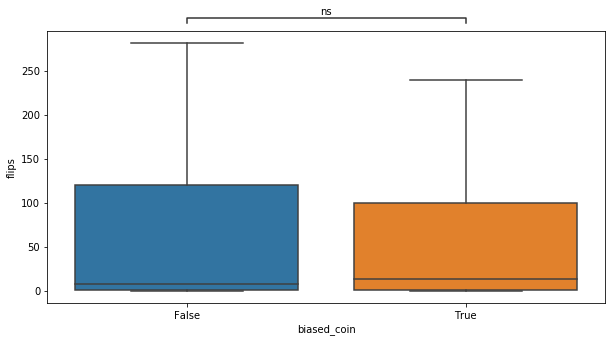

--------------------------------------------------
Jeroslow var_picks 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=7.199e-01 stat=3.589e-01


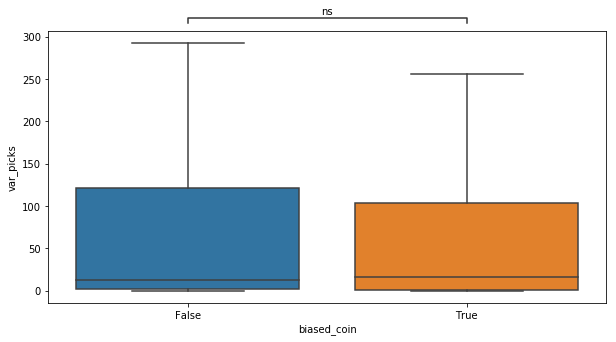

--------------------------------------------------
Jeroslow norm_simplifications 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=7.031e-01 stat=3.814e-01


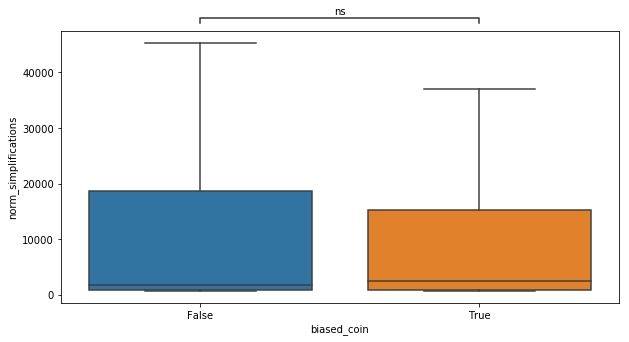

--------------------------------------------------
Jeroslow norm_simplifications 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False v.s. True: t-test independent samples, P_val=7.031e-01 stat=3.814e-01


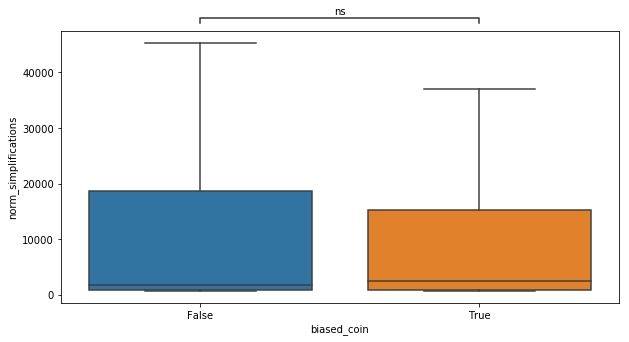

In [119]:
# Boxplot biased coin with t_tests
log_metrics =["log_backtracks", "log_flips", "log_var_picks", "log_simplifications"]
metrics =["backtracks", "flips", "var_picks", "norm_simplifications"]

for heuristic in heuristics:
    for metric in metrics:
        plot_biased_boxplot(heuristic, metric)

plot_biased_boxplot(heuristic, metric)

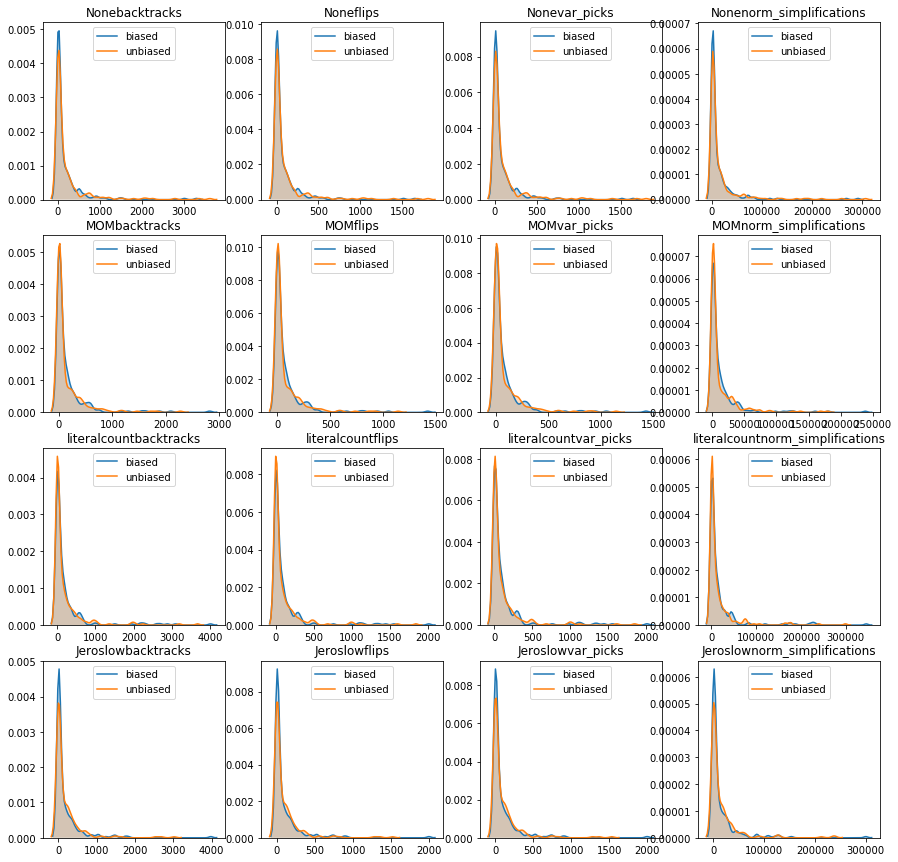

In [120]:
# TODO: Select relevant heuristic
plt.figure(figsize=(15,15))

h = len(heuristics)
m = len(metrics)
i=1
for heuristic in heuristics:
    for metric in metrics:
        plt.subplot(h,m,i)
        plot_biased_distribution(heuristic, metric)
        i+=1

plt.show()

### Compression Effect

- Pick a heuristic
- Pick a biased_coin
- Plot compression metrics against file_name

In [121]:
def plot_compression_with_file(heuristic, metric):
    print("-"*50)
    print(heuristic, metric, "\n")
    df_compression = df_biased
    df_compression = df_compression.loc[(df_compression["heuristic"] == str(heuristic))]
    ax = sns.boxplot(y=metric, x="file_name", showfliers=False, orient = "v", data=df_compression)
    add_stat_annotation(ax, data=df_compression, y=metric, x="file_name",
                    boxPairList=[("100_easy_sudokus", "damnhard.sdk"),
                                 ("100_easy_sudokus", "top91.sdk"),
                                 ("damnhard.sdk", "top91.sdk")],
                    test='t-test_ind', textFormat='star', loc='outside', verbose=2)    
    plt.show()

--------------------------------------------------
None bit_length 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100_easy_sudokus v.s. damnhard.sdk: t-test independent samples, P_val=5.989e-01 stat=5.273e-01
100_easy_sudokus v.s. top91.sdk: t-test independent samples, P_val=5.170e-07 stat=5.199e+00
damnhard.sdk v.s. top91.sdk: t-test independent samples, P_val=3.400e-03 stat=2.987e+00


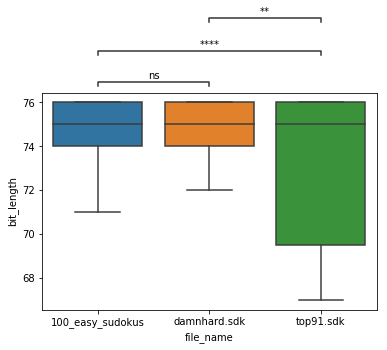

--------------------------------------------------
None mean_compression 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100_easy_sudokus v.s. damnhard.sdk: t-test independent samples, P_val=5.770e-02 stat=1.915e+00
100_easy_sudokus v.s. top91.sdk: t-test independent samples, P_val=5.602e-03 stat=-2.802e+00
damnhard.sdk v.s. top91.sdk: t-test independent samples, P_val=1.197e-03 stat=-3.316e+00


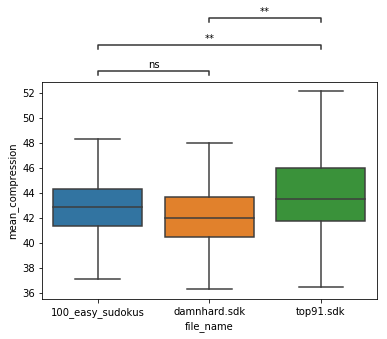

--------------------------------------------------
MOM bit_length 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100_easy_sudokus v.s. damnhard.sdk: t-test independent samples, P_val=5.989e-01 stat=5.273e-01
100_easy_sudokus v.s. top91.sdk: t-test independent samples, P_val=5.170e-07 stat=5.199e+00
damnhard.sdk v.s. top91.sdk: t-test independent samples, P_val=3.400e-03 stat=2.987e+00


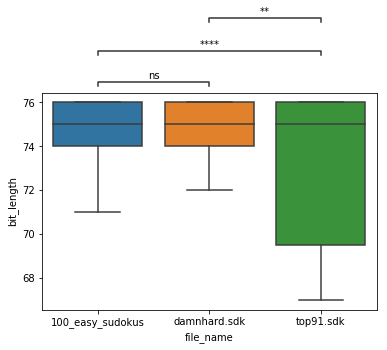

--------------------------------------------------
MOM mean_compression 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100_easy_sudokus v.s. damnhard.sdk: t-test independent samples, P_val=5.770e-02 stat=1.915e+00
100_easy_sudokus v.s. top91.sdk: t-test independent samples, P_val=5.602e-03 stat=-2.802e+00
damnhard.sdk v.s. top91.sdk: t-test independent samples, P_val=1.197e-03 stat=-3.316e+00


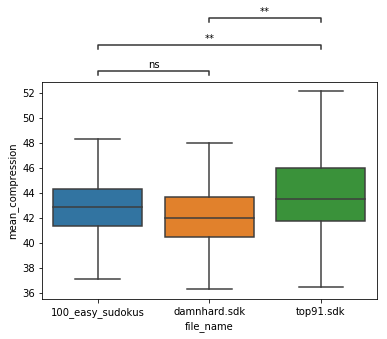

--------------------------------------------------
literalcount bit_length 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100_easy_sudokus v.s. damnhard.sdk: t-test independent samples, P_val=5.989e-01 stat=5.273e-01
100_easy_sudokus v.s. top91.sdk: t-test independent samples, P_val=5.170e-07 stat=5.199e+00
damnhard.sdk v.s. top91.sdk: t-test independent samples, P_val=3.400e-03 stat=2.987e+00


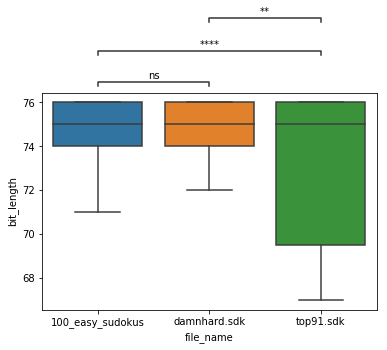

--------------------------------------------------
literalcount mean_compression 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100_easy_sudokus v.s. damnhard.sdk: t-test independent samples, P_val=5.770e-02 stat=1.915e+00
100_easy_sudokus v.s. top91.sdk: t-test independent samples, P_val=5.602e-03 stat=-2.802e+00
damnhard.sdk v.s. top91.sdk: t-test independent samples, P_val=1.197e-03 stat=-3.316e+00


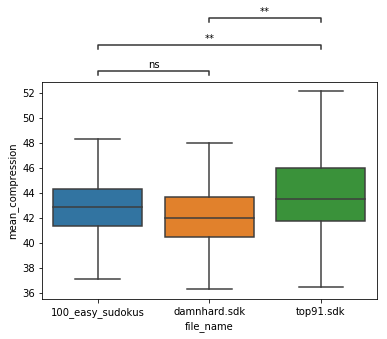

--------------------------------------------------
Jeroslow bit_length 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100_easy_sudokus v.s. damnhard.sdk: t-test independent samples, P_val=5.989e-01 stat=5.273e-01
100_easy_sudokus v.s. top91.sdk: t-test independent samples, P_val=5.170e-07 stat=5.199e+00
damnhard.sdk v.s. top91.sdk: t-test independent samples, P_val=3.400e-03 stat=2.987e+00


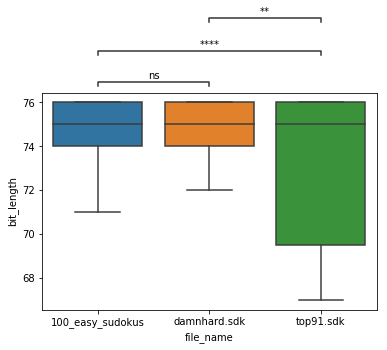

--------------------------------------------------
Jeroslow mean_compression 

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

100_easy_sudokus v.s. damnhard.sdk: t-test independent samples, P_val=5.770e-02 stat=1.915e+00
100_easy_sudokus v.s. top91.sdk: t-test independent samples, P_val=5.602e-03 stat=-2.802e+00
damnhard.sdk v.s. top91.sdk: t-test independent samples, P_val=1.197e-03 stat=-3.316e+00


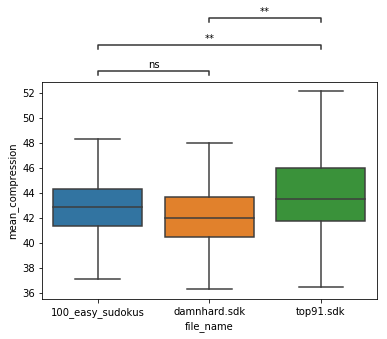

In [122]:
compression_metrics = ["bit_length", "mean_compression"]

for heuristic in heuristics:
    for metric in compression_metrics:
        plot_compression_with_file(heuristic, metric)

plt.show()

- Plot correlation of metrics against mean_compression


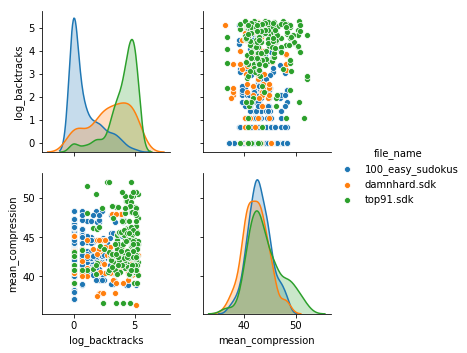

In [123]:
compression_metric = ["mean_compression"]
performance_metrics = ["log_backtracks"]
interesting_columns = performance_metrics + compression_metric

sns.pairplot(df_biased[df_biased['backtracks'] <= 200], vars=interesting_columns, hue = "file_name")
plt.show()

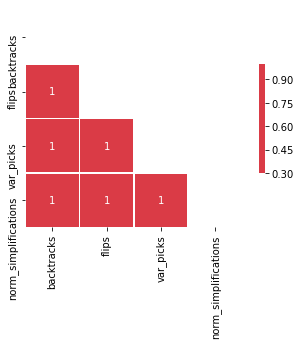

In [131]:
# Compute the correlation matrix
metrics =["backtracks", "flips", "var_picks", "norm_simplifications"]
corr = df_biased[metrics].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig("./images/variable_selection.eps" , bbox_inches='tight')
plt.show()


In [132]:
df_biased.head()

,backtracks,flips,var_picks,norm_simplifications,heuristic,biased_coin,bit_length,mean_compression,file_name,log_backtracks,log_flips,flips_ratio,log_var_picks,log_norm_simplifications
0,3.0,2.0,2.0,876.0,None,True,76.0,47.1,100_easy_sudokus,1.386294,1.098612,0.500000,1.098612,5.393628
1,2.0,2.0,3.0,808.0,MOM,True,76.0,47.1,100_easy_sudokus,1.098612,1.098612,0.666667,1.386294,5.599656
2,0.0,0.0,3.0,726.0,literalcount,True,76.0,47.1,100_easy_sudokus,0.000000,0.000000,0.000000,1.386294,6.588926
3,3.0,3.0,4.0,905.0,Jeroslow,True,76.0,47.1,100_easy_sudokus,1.386294,1.386294,0.750000,1.609438,5.426051
4,0.0,0.0,0.0,729.0,None,True,74.0,43.2,100_easy_sudokus,0.000000,0.000000,0.000000,0.000000,6.593045


- Show correlation of metrics
- Pick one metric
- Show heuristics plot for a single metric
- Pick a metric
- Show boxplot for biased coin
- Pick a biased coin
- Show compression results

